<a href="https://colab.research.google.com/github/tq21/ML-Stuff/blob/master/NLP_word_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [9]:
!curl https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv \
    -o /tmp/bbc-text.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4938k  100 4938k    0     0   102M      0 --:--:-- --:--:-- --:--:--  102M


In [10]:
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [11]:
# hyperparameters
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_portion = 0.8

In [13]:
sentences = []
labels = []

with open("/tmp/bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        sentence = row[1]
        for word in stopwords:
            token = " " + word + " "
            sentence = sentence.replace(token, " ")
            sentence = sentence.replace("  ", " ")
        sentences.append(sentence)

print("Number of sentences: {}".format(len(sentences)))

Number of sentences: 2225


In [14]:
train_size = int(len(sentences) * training_portion)

train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

valid_sentences = sentences[train_size:]
valid_labels = labels[train_size:]

print("Training sentences size: {}".format(len(train_sentences)))
print("Training labels size: {}".format(len(train_labels)))
print("Validation sentences size: {}".format(len(valid_sentences)))
print("Validation labels size: {}".format(len(valid_labels)))

Training sentences size: 1780
Training labels size: 1780
Validation sentences size: 445
Validation labels size: 445


In [16]:
# Tokenize training sentences, padding
tokenizer = Tokenizer(num_words=vocab_size,
                      oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
train_seq = tokenizer.texts_to_sequences(train_sentences)
train_pad = pad_sequences(train_seq,
                          padding=padding_type,
                          truncating=trunc_type,
                          maxlen=max_length)

print("Shape padded (training): {}".format(train_pad.shape))

Shape padded (training): (1780, 120)


In [19]:
# Tokenize validation sentences, padding
valid_seq = tokenizer.texts_to_sequences(valid_sentences)
valid_pad = pad_sequences(valid_seq,
                          padding=padding_type,
                          truncating=trunc_type,
                          maxlen=max_length)

print("Shape padded (validation): {}".format(valid_pad.shape))

Shape padded (validation): (445, 120)


In [25]:
# Tokenize labels
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)
label_word_index = label_tokenizer.word_index

train_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
valid_label_seq = np.array(label_tokenizer.texts_to_sequences(valid_labels))

print("Shape training labels: {}".format(train_label_seq.shape))
print("Shape validation labels: {}".format(valid_label_seq.shape))
print(label_word_index)

Shape training labels: (1780, 1)
Shape validation labels: (445, 1)
{'sport': 1, 'business': 2, 'politics': 3, 'tech': 4, 'entertainment': 5}


In [29]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           16000     
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 150       
Total params: 16,558
Trainable params: 16,558
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = model.fit(
    train_pad,
    train_label_seq,
    epochs=30,
    validation_data=(valid_pad, valid_label_seq)
)

Epoch 1/30
56/56 [==============================] - 0s 5ms/step - loss: 1.7708 - accuracy: 0.2320 - val_loss: 1.7412 - val_accuracy: 0.2629
Epoch 2/30
56/56 [==============================] - 0s 2ms/step - loss: 1.7015 - accuracy: 0.3933 - val_loss: 1.6503 - val_accuracy: 0.4225
Epoch 3/30
56/56 [==============================] - 0s 3ms/step - loss: 1.5903 - accuracy: 0.4399 - val_loss: 1.5243 - val_accuracy: 0.4584
Epoch 4/30
56/56 [==============================] - 0s 2ms/step - loss: 1.4367 - accuracy: 0.4556 - val_loss: 1.3575 - val_accuracy: 0.4674
Epoch 5/30
56/56 [==============================] - 0s 3ms/step - loss: 1.2532 - accuracy: 0.4916 - val_loss: 1.1813 - val_accuracy: 0.5820
Epoch 6/30
56/56 [==============================] - 0s 2ms/step - loss: 1.0659 - accuracy: 0.6202 - val_loss: 1.0108 - val_accuracy: 0.7191
Epoch 7/30
56/56 [==============================] - 0s 2ms/step - loss: 0.8916 - accuracy: 0.7983 - val_loss: 0.8609 - val_accuracy: 0.8270
Epoch 8/30
56/56 [==

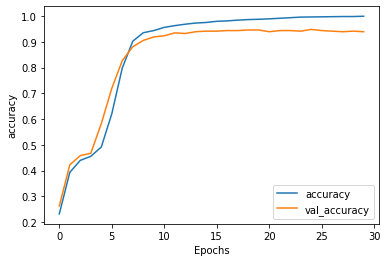

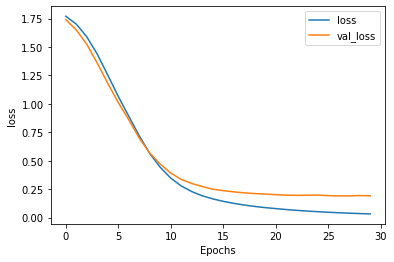

In [31]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")